<a href="https://www.kaggle.com/code/dsptlp/spark?scriptVersionId=164476420" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://spark.apache.org/docs/3.1.3/api/python/_static/spark-logo-reverse.png" alt="Sample Image" width="200"/>

# SPARK 
- Reasons to Use Spark
- This notebook will compare Spark VS scikit-learn

# NOTE 
- Spark is designed to work in a distributed computing environment and is most effective when dealing with large datasets and clusters of machines. 
- In Kaggle's limited environment, we are not using a distributed computing environment but will be able to use all the computer resources which will be the only benefit. 

# SPARK ADVANTAGES

1. **Speed:** Spark is known for its speed, as it can perform in-memory processing, reducing the need to write intermediate results to disk. This makes Spark well-suited for iterative algorithms and interactive data analysis.

2. **Ease of Use:** Spark provides high-level APIs in languages such as Scala, Java, Python, and R, making it accessible to a wide range of users. It also offers built-in libraries for various tasks like SQL, machine learning (MLlib), graph processing (GraphX), and stream processing (Spark Streaming).

3. **Scalability:** Spark is designed for distributed computing, allowing it to scale horizontally across a cluster of machines. This makes it suitable for handling large datasets and processing tasks that would be challenging for single-node systems.

4. **Versatility:** Spark supports a variety of data processing scenarios, including batch processing, interactive queries, streaming analytics, and machine learning. This versatility makes it a preferred choice for organizations with diverse data analysis needs.

5. **Fault Tolerance:** Spark provides fault tolerance through lineage information and resilient distributed datasets (RDDs). If a node fails, Spark can recompute the lost data using the lineage information, ensuring the reliability of data processing.

6. **Integration with Big Data Ecosystem:** Spark seamlessly integrates with other big data tools and technologies, such as Hadoop Distributed File System (HDFS), Apache Hive, Apache HBase, and more. This allows users to leverage existing data storage and processing systems.

7. **Community Support:** Spark has a large and active open-source community. This means continuous development, improvements, and a wealth of resources, including documentation, forums, and tutorials.

8. **In-Memory Processing:** Spark's ability to store intermediate data in memory rather than writing to disk can significantly improve performance, especially for iterative algorithms and interactive data analysis, compared to traditional disk-based processing.


In [1]:
# Install PySpark
try:
    import pyspark
except ImportError:
    print("pyspark not found. Installing...")
    !pip install pyspark > pyspark.log.txt
    print("pyspark installed successfully!")

pyspark not found. Installing...
pyspark installed successfully!


In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

from matplotlib import cm
import numpy as np 
import pandas as pd
import seaborn as sns
import warnings
import timeit

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as PandasRFClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  as ScikitPCA
from sklearn.preprocessing import StandardScaler

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Create a Spark session
#spark = SparkSession.builder.appName("Spark").getOrCreate()

# Create a Spark session with local[*] master to use all available cores
spark = SparkSession.builder.master("local[*]").appName("PCAExample").getOrCreate()

# Set log level to OFF 
spark.sparkContext.setLogLevel("OFF")

# Print the Spark version
print("Spark Version:", spark.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/27 04:02:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.1


# LOADING DATA

In [4]:
file_path  = "/kaggle/input/tabular-dataset-ready-for-malicious-url-detection/test_dataset.csv"
column_list = ['label','url_has_login','url_has_client','url_has_server','url_len']

runs = 1

measures = []

row_count = 10000

## SPARK

In [5]:
def load_csv_using_spark():
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Perform the summary: count number of records grouped by a column
    summary_df = df.groupBy("label").count()
    
    # Perform an action (triggers execution, note that spark uses Lazy Execution)
    summary_df.collect() #show()
    
    return df
    
# Measure the execution time
execution_time = timeit.timeit(load_csv_using_spark, number=runs)

# Print the result
print(f"Execution time using SPARK: {execution_time} seconds")
measures.append(('SPARK','load_csv',execution_time))

spark_df = load_csv_using_spark()
spark_df = spark_df.select(column_list)

Execution time using SPARK: 32.60228547600002 seconds


## PANDAS

In [6]:
def load_csv_using_pandas():
    data_df = pd.read_csv(file_path, delimiter=',') 
    summary_df = data_df[['url_has_login','label']].groupby(['label']).count()
    return data_df
    
# Measure the execution time
execution_time = timeit.timeit(load_csv_using_pandas, number=runs)

# Print the result
print(f"Execution time using PANDAS: {execution_time} seconds")
measures.append(('PANDAS','load_csv',execution_time))

pandas_df = load_csv_using_pandas()
pandas_df = pandas_df[column_list]

Execution time using PANDAS: 16.59140448900007 seconds


# PCA

## SPARK

In [7]:
def pca_csv_using_spark():
    
    numericColsAll  = ['url_has_login','url_has_client','url_has_server','url_len']
    label = 'label'

    #VECTORIZE NUMERIC COLS
    assembler = VectorAssembler(inputCols=numericColsAll , outputCol="Numfeatures")
    df = assembler.transform(spark_df)

    # Apply PCA
    pca = PCA(k=2, inputCol="Numfeatures", outputCol="pca_features")
    model = pca.fit(df)
    result = model.transform(df)

    # Show the result
    result.select("Numfeatures", "pca_features").show(truncate=False)

    # Extract data for plotting
    #features_and_labels = result.select("pca_features").rdd.map(lambda row: (row.pca_features,))

    # Collect transformed features and labels
    #features, = zip(*features_and_labels.collect())

    # Extract labels from the original DataFrame
    #labels = result.select(label).rdd.map(lambda row: row[label]).collect()

    # Create a color map with a unique color for each label
    #label_colors = ListedColormap(['red', 'green', 'blue', 'orange'])  # Add more colors if needed

    # Plot the data points with different colors for each label
    #for i, label in enumerate(labels):
    #    plt.scatter(features[i][0], features[i][1], label=f"Label {label}", color=label_colors(label))

    #plt.title("PCA Visualization with Labels")
    #plt.xlabel("Principal Component 1")
    #plt.ylabel("Principal Component 2")
    #plt.legend()
    #plt.show()
    
# Measure the execution time
execution_time = timeit.timeit(pca_csv_using_spark, number=runs)

# Print the result
print(f"Execution time using SPARK: {execution_time} seconds")
measures.append(('SPARK','PCA',execution_time))

+---------------+------------------------------------------+
|Numfeatures    |pca_features                              |
+---------------+------------------------------------------+
|(4,[3],[15.0]) |[-14.999992762772708,0.014593764420371413]|
|(4,[3],[12.0]) |[-11.999994210218166,0.01167501153629713] |
|(4,[3],[12.0]) |[-11.999994210218166,0.01167501153629713] |
|(4,[3],[15.0]) |[-14.999992762772708,0.014593764420371413]|
|(4,[3],[29.0]) |[-28.999986008027236,0.028214611212718066]|
|(4,[3],[21.0]) |[-20.99998986788179,0.02043127018851998]  |
|(4,[3],[33.0]) |[-32.999984078099956,0.03210628172481711] |
|(4,[3],[25.0]) |[-24.99998793795451,0.024322940700619022] |
|(4,[3],[33.0]) |[-32.999984078099956,0.03210628172481711] |
|(4,[3],[21.0]) |[-20.99998986788179,0.02043127018851998]  |
|(4,[3],[35.0]) |[-34.99998311313632,0.03405211698086663]  |
|(4,[3],[13.0]) |[-12.999993727736346,0.012647929164321892]|
|(4,[3],[118.0])|[-117.9999430671453,0.11480428010692179]  |
|(4,[3],[20.0]) |[-19.99

## SCIKIT-LEARN

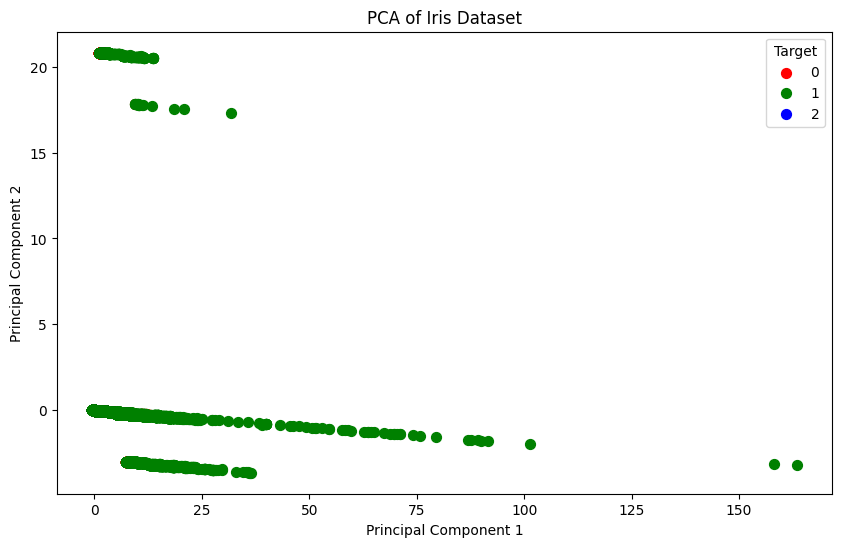

Execution time using Scikit-learn: 19.109239983000066 seconds


In [8]:
def pca_csv_using_scikit_learn():

    numericColsAll  = ['url_has_login','url_has_client','url_has_server','url_len']
    label = 'label'

    # Assuming your dataframe is 'pandas_df'
    # Extract the features and target variable
    X = pandas_df.drop(label, axis=1)  # Replace 'target_column' with the actual target column name
    y = pandas_df[label]

    # Standardize the data (optional but recommended for PCA)
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler().fit_transform(X)

    # Apply PCA with 2 components
    pca = ScikitPCA(n_components=2)
    X_pca = pca.fit_transform(X_std)

    # Create a DataFrame with the principal components and target variable
    df = pd.DataFrame(data=np.c_[X_pca, y], columns=['PC1', 'PC2', 'Target'])

    # Plot the data in the new 2D space
    plt.figure(figsize=(10, 6))
    targets = [0, 1, 2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        indices_to_keep = df['Target'] == target
        plt.scatter(df.loc[indices_to_keep, 'PC1'],
                    df.loc[indices_to_keep, 'PC2'],
                    c=color, s=50)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(targets, title='Target')
    plt.title('PCA of Iris Dataset')
    plt.show()
    
# Measure the execution time
execution_time = timeit.timeit(pca_csv_using_scikit_learn, number=runs)

# Print the result
print(f"Execution time using Scikit-learn: {execution_time} seconds")
measures.append(('Scikit','PCA',execution_time))

# RANDOMFOREST

## SPARK

In [9]:
def rf_using_spark():
    numericColsAll  = ['url_has_login','url_has_client','url_has_server','url_len']
    label = 'label'

    #VECTORIZE NUMERIC COLS
    assembler = VectorAssembler(inputCols=numericColsAll , outputCol="Numfeatures")
    df = assembler.transform(spark_df)

    # Split the data into training and testing sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Create the RandomForestClassifier
    rf = SparkRFClassifier(featuresCol="Numfeatures", labelCol="label")

    # Create a pipeline
    pipeline = Pipeline(stages=[rf])

    # Set up a parameter grid and cross-validator
    paramGrid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 20, 30])
                 .addGrid(rf.maxDepth, [5, 10, 15])
                 .build())

    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5)

    # Fit the model
    cv_model = crossval.fit(train_data)

    # Make predictions on the test set
    predictions = cv_model.transform(test_data)

    # Evaluate the model
    area_under_roc = evaluator.evaluate(predictions)
    print(f"Area under ROC: {area_under_roc}")
    
# Measure the execution time
execution_time = timeit.timeit(rf_using_spark, number=runs)

# Print the result
print(f"Execution time using SPARK: {execution_time} seconds")
measures.append(('SPARK','RF',execution_time))    

Area under ROC: 0.838594217690003
Execution time using SPARK: 1273.8635288630003 seconds


## scikit-learn

In [10]:
def rf_using_scikit():

    # Split the data into features (X) and target variable (y)
    X = pandas_df.drop("label", axis=1)  
    y = pandas_df["label"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [50],
        'max_depth': [5, 10, 15]
    }

    # Build the RandomForest model
    rf = PandasRFClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

    # Create GridSearchCV
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')

    # Fit the model with the best parameters found by grid search
    grid_search.fit(X_train, y_train)

    # Get the best parameters from the grid search
    best_params = grid_search.best_params_

    # Get the best model from the grid search
    best_rf = grid_search.best_estimator_

    # Perform cross-validation
    cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')

    # Fit the best model on the full training set
    best_rf.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = best_rf.predict(X_test)

    # Evaluate the best model
    area_under_roc = roc_auc_score(y_test, predictions)
    print(f"Area under ROC: {area_under_roc}")

        
# Measure the execution time
execution_time = timeit.timeit(rf_using_scikit, number=runs)

# Print the result
print(f"Execution time using SCIKIT: {execution_time} seconds")
measures.append(('SCIKIT','RF',execution_time)) 

Area under ROC: 0.7045601702155285
Execution time using SCIKIT: 458.69565762599996 seconds


# FINAL RESULTS

In [11]:
print(measures)

[('SPARK', 'load_csv', 32.60228547600002), ('PANDAS', 'load_csv', 16.59140448900007), ('SPARK', 'PCA', 15.452086953000048), ('Scikit', 'PCA', 19.109239983000066), ('SPARK', 'RF', 1273.8635288630003), ('SCIKIT', 'RF', 458.69565762599996)]
